In [1]:
import os
import sys

import json
import pickle

import scipy
import seaborn as sns

import numpy as np
import pandas as pd
from dtw import dtw
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
import dcor

In [162]:
data = pd.read_csv("../data/data.csv")
data.rename(columns = {0:'Date'}, inplace = False)
cols = data.columns.tolist()
cols = cols[-1:]+cols[1:-1]
data  = data[cols]
data["Date"] = pd.to_datetime(data["Date"])
data = data.set_index("Date")
data.index = data.index - pd.Timedelta(days = 1)

meta = pd.read_csv("../data/meta.csv")

In [4]:
number_of_nans = data.isna().sum()
usable = number_of_nans[number_of_nans < 1000].index
data_nans_removed = data[usable].interpolate()
data_nans_removed

,1515,1516,1518,1521,1719,1722,1723,2040,2046,2048,...,1527,1729,1726,2541,1530,1734,2741,2545,210888,210900
Date,,,,,,,,,,,,,,,,,,,,,
1950-12-31,-114.0,-8.0,-88.0,130.0,238.5,204.5,194.5,305.0,408,376.0,...,-14,125.5,125.0,120.0,50.0,73.0,217.0,18.0,438.0,414.0
1951-01-01,-122.0,-22.0,-102.0,110.0,200.5,182.5,160.5,260.0,376,330.0,...,-16,117.5,125.0,86.0,28.0,81.0,146.0,20.0,417.0,400.0
1951-01-02,-129.0,-32.0,-119.0,80.0,164.5,164.5,114.5,220.0,334,291.0,...,-18,116.5,121.0,50.0,30.0,73.0,108.0,16.0,390.0,388.0
1951-01-03,-134.0,-36.0,-124.0,60.0,132.5,128.5,88.5,182.0,286,242.0,...,-20,108.5,121.0,24.0,25.0,67.0,82.0,16.0,360.0,370.0
1951-01-04,-153.0,-52.0,-135.0,50.0,110.5,108.5,80.5,147.0,239,195.0,...,-22,106.5,119.0,0.0,32.0,63.0,60.0,6.0,322.0,349.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,-27.0,75.0,-69.0,309.0,478.0,138.0,204.0,451.0,-78,-153.0,...,148,46.0,54.0,48.0,155.0,52.0,74.0,-18.0,272.0,325.0
2020-12-27,-94.0,21.0,-50.0,333.0,488.0,206.0,252.0,464.0,20,-101.0,...,162,45.0,52.0,128.0,154.0,42.0,82.0,-17.0,272.0,325.0
2020-12-28,-137.0,-20.0,-92.0,311.0,481.0,201.0,250.0,461.0,120,-2.0,...,154,46.0,63.0,116.0,145.0,40.0,83.0,-22.0,272.0,325.0


In [82]:
def pearson(dx, dy):
    return scipy.stats.pearsonr(dx,dy)

def spearman(dx,dy):
    return scipy.stats.spearmanr(dx,dy)

def distance_correlation(dx,dy):
    return dcor.distance_correlation(dx, dy),0

def timewarping(dx,dy):
    distance, cost_matrix, acc_cost, path = dtw(np.array(dx).reshape(-1,1),np.array(dy).reshape(-1,1), dist = scipy.spatial.distance.euclidean)
    return distance

def corr(df,starting_point,interval,method,l,pv,p1):
    period2 = df[(df.index >= starting_point - interval) & (df.index <= starting_point + interval)]

    for col in df.columns.tolist():
        cor, p_value = method(p1['2275'],period2[col])
        l.append(cor)
        pv.append(p_value)



def calculate_correlations(df,starting_point,interval,method):

    day = pd.Timedelta(1,'d')
    sp = starting_point
    l = []
    pv = []

    period1 = df[(df.index >= starting_point - interval) & (df.index <= starting_point + interval)]
    for i in np.linspace(0,5,5):
        starting_point = starting_point + day
        corr(df,starting_point,interval,method,l,pv,period1)
    starting_point =  sp + day
    for i in np.linspace(0,50,50):
        starting_point = starting_point - day
        corr(df,starting_point,interval,method,l,pv,period1)

    cm = np.transpose(np.reshape(np.array(l), (-1, len(df.columns))))
    pv = np.transpose(np.reshape(np.array(pv), (-1, len(df.columns))))

    return cm, pv


correlation_matrix, p_values = calculate_correlations(data_nans_removed,pd.Timestamp('2006-01-01'),pd.Timedelta(52,'w'),pearson)

In [83]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(data_nans_removed[['2275','1515']], maxlag =[8])


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=803.6106, p=0.0000  , df_denom=25543, df_num=8
ssr based chi2 test:   chi2=6433.1633, p=0.0000  , df=8
likelihood ratio test: chi2=5738.0565, p=0.0000  , df=8
parameter F test:         F=803.6106, p=0.0000  , df_denom=25543, df_num=8


{8: ({'ssr_ftest': (803.6105689040489, 0.0, 25543.0, 8),
   'ssr_chi2test': (6433.1632591903835, 0.0, 8),
   'lrtest': (5738.0564751477505, 0.0, 8),
   'params_ftest': (803.6105689040236, 0.0, 25543.0, 8.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0.]])])}

In [84]:
p_values

array([[7.22942098e-122, 1.11287269e-110, 5.28499548e-101, ...,
        9.46911410e-019, 2.77717065e-017, 5.40063372e-016],
       [6.85684906e-131, 5.55888889e-118, 1.37661083e-106, ...,
        1.12110850e-023, 4.15467687e-022, 1.02163528e-020],
       [1.60944805e-156, 1.97722563e-140, 1.98276840e-126, ...,
        2.20764986e-024, 6.32398108e-023, 1.20995667e-021],
       ...,
       [4.21049849e-101, 7.61203853e-093, 3.49889910e-085, ...,
        4.27317530e-043, 3.43333195e-042, 3.08184034e-041],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.10792864e-022, 3.66650859e-021, 6.20312895e-020],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        9.64302301e-019, 2.21936364e-017, 4.41487216e-016]])

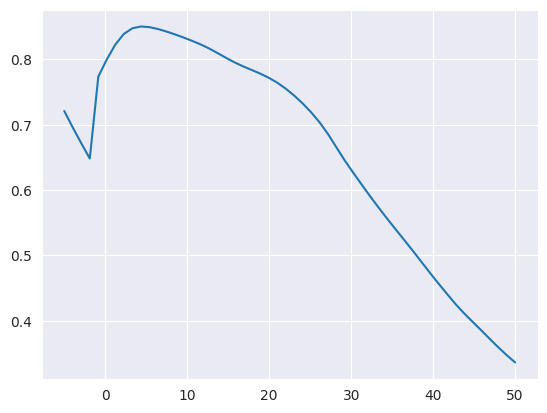

In [85]:
plt.plot(np.linspace(-5,50,54),np.transpose(correlation_matrix[1,1:100]))

In [129]:
cr = pd.DataFrame(data = np.transpose(correlation_matrix), columns=data_nans_removed.columns)
cr.idxmax() - 5

1515      6
1516      5
1518      4
1521      5
1719      9
1722      3
1723      3
2040      2
2046      1
2048      0
2271      0
2272      0
2274      0
2275      0
2278      2
2543      2
2753      5
2756      4
1514      5
1523      6
2736      8
1721      3
1724      4
1725      4
1520      4
1527      5
1729      4
1726      6
2541      3
1530      7
1734      5
2741      4
2545      5
210888    0
210900    0
dtype: int64

In [213]:
max_corr = pd.Series((cr.idxmax() - 5),name="maximum_correlation")
max_corr.index = max_corr.index.astype(int)

In [217]:
meta = pd.read_csv("../data/meta.csv")
meta = meta.set_index("reg_number")

meta_nans_removed = meta.loc[list(map(int,cr.columns.tolist()))]
meta_nans_removed = pd.concat([meta_nans_removed, max_corr], axis=1)


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not a

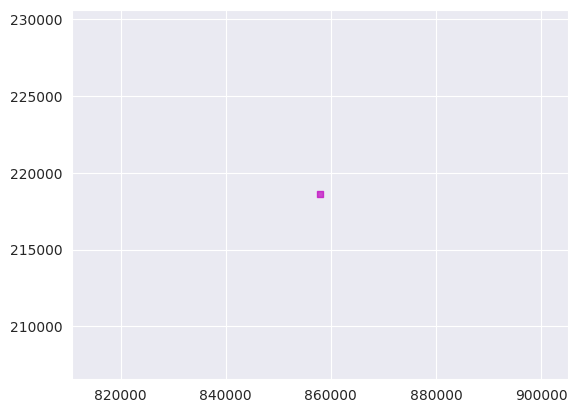

In [223]:

from mlxtend.plotting import category_scatter

fig = category_scatter(x='EOVx', y='EOVy', label_col='river', colors='maximum_correlation',
                       data=meta_nans_removed, legend_loc='upper right')